## This notebook is used for the analysis of simulations carried out with SOMA

#### It should only be used for binary homopolymer blends. It is used to calculate the boundary densities and currents in the case where polymer types A and B are  being converted into each other at the x boundaries at a specific rate. There is also an analytical approach to this, which depends on the single chain diffusion coefficient, which in turn needs to be extracted from the simulation. All the calculations are done for type A.


In [18]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

0.20684650979442654
74


/var/folders/f5/zmpl7j_93n5bz1wd70hgb4140000gn/T/ipykernel_2466/4252250241.py:68: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


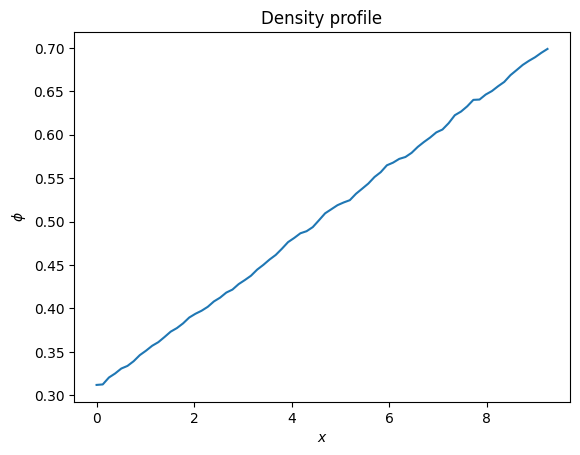

In [40]:


area51_len=3
##length of area51 in x direction. Need to exclude this for density profile calculations
area51_len = area51_len
with h5py.File('coord.h5', 'r') as f:
    ##number of beads per polymer
    N=int(f['parameter/reference_Nbeads'][()]) 
    ##number of polymers
    n_polym=int(f['parameter/n_polymers'][()]) 
    n_poly_type=int(f['parameter/n_poly_type'][()]) 
    ##box dimensions 
    lxyz=np.array(f['parameter/lxyz'])
    ##box discretization
    nxyz=np.array(f['parameter/nxyz'])
    ##true lx (without area51)
    lx_true=(nxyz[0]-2*area51_len)/nxyz[0]*lxyz[0]
    ##conversion rate for each reaction
    rates=np.array(f['polyconversion/rate'])
    ##number of area 51 cells
    area51=sum(np.array(f['area51']).flatten())

    
##load analysis data
with h5py.File('coord_ana.h5', 'r') as f:
    ##density field averaged over time, y and z
    phi=np.array(f['density_field']).mean(axis=(0,3,4))[:,area51_len:nxyz[0]-area51_len]
    ##numbers of polymers converted per reaction
    num_conversions=np.array(f['num_conversions']) 
    delta_mc_num_conversions=np.array(f['num_conversions'].attrs["DeltaMC"])
    ##MSD
    MSD=np.array(f['MSD'])
    
    

##cell volume
V_cell=np.prod(lxyz)/np.prod(nxyz)
##total simulation time
t=delta_mc_num_conversions*len(num_conversions)
##accessible volume
V=np.prod(lxyz)-V_cell*area51
##field scaling factor
scale=(np.prod(nxyz)-area51)/(N*n_polym)
phi=phi*scale
##Nbar
Nbar=n_polym/V
##average bead density
rho0=n_polym*N/V
## diffusion coefficients
D_A=MSD[:,3][-1]/(6*t)
D_B=MSD[:,11][-1]/(6*t)
##onsager coefficients (without density factor)
lam_A=D_A*N
lam_B=D_B*N

    

def plot_density_profile(poly_type=0):
    """Plot x coordinate density profile.
    """
    xmin=0
    xmax=lx_true
    x_grid=np.linspace(xmin,xmax,nxyz[0]-2*area51_len)
    fig=plt.figure(dpi=100)
    plt.title("Density profile")
    plt.xlabel("$x$")
    plt.ylabel("$\phi$")
    print(len(x_grid))
    plt.plot(x_grid,phi[poly_type,:])
    fig.show()
    return

def poly_current_num(reaction=2):
    """Polymer current over whole simulation time. Assumes that current is only in x direction and that it is proportional to the number of polymer conversions.

    """
    
    ##get polymer current per deltamc
    A=lxyz[1]*lxyz[2]
    j=np.array([num_conversions[i+1,2]-num_conversions[i,2] for i in range(1,len(num_conversions)-1)])/(delta_mc_num_conversions*A)
    
    
    J_mean=np.mean(j)
    return J_mean * N


def delta_phi():
    """Analytical equation for the density profile slope.
    """
    return poly_current_num()/(rho0*D_A)

def phi0_ana():
    """Analytical equation for the density profile at x=0.
    """
    return 0.5-0.5*delta_phi()*lx_true
    
print(phi0_ana())
plot_density_profile()

In [33]:
area51_len = 3

In [21]:
a=SOMA_run(0,area51_len)

NameError: name 'SOMA_run' is not defined

In [22]:
runs=[]
for i in range(10):
    runs.append(SOMA_run(i,area51_len))

NameError: name 'SOMA_run' is not defined

In [23]:
rates=np.array([])
J_num=np.array([])
J_ana=np.array([])
phi0_ana=np.array([])
phi0_num=np.array([])
for i in range(10):
    test=runs[i]
    rate=test.rates[0]
    J_num=np.append(J_num,test.poly_current_num(2))
    J_ana=np.append(J_ana,test.poly_current_ana(rate))
    phi0_ana=np.append(phi0_ana,test.phi0_ana())
    phi0_num=np.append(phi0_num,test.mean_dens(0))
    rates=np.append(rates,rate)
print(phi0_ana)

IndexError: list index out of range

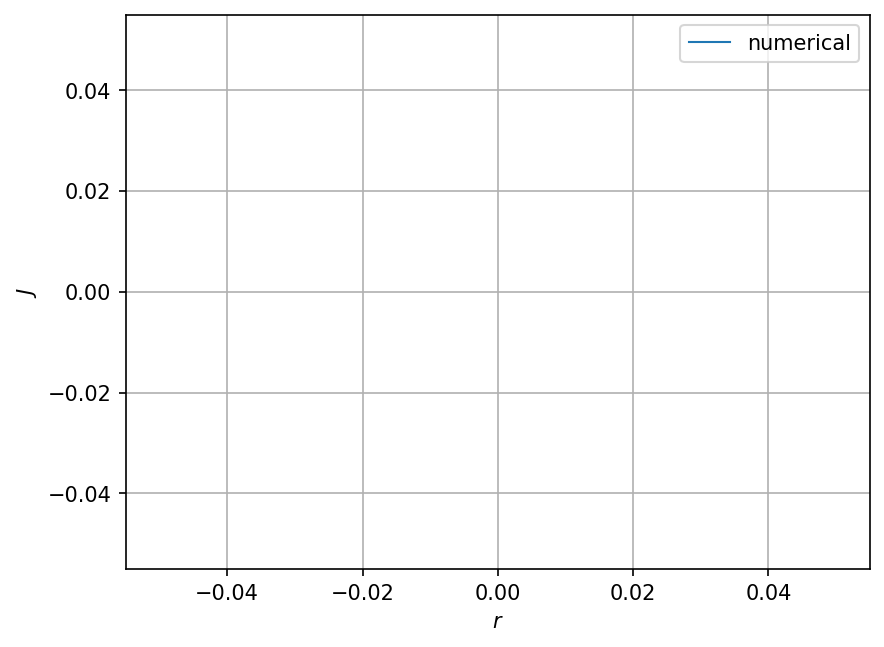

In [24]:
plt.figure(dpi=150)
plt.grid()
plt.xlabel("$r$")
plt.ylabel("$J$")
plt.plot(rates,J_num,label="numerical",lw=1)
#plt.plot(rates,J_ana,label="analytical",lw=1)
plt.legend()

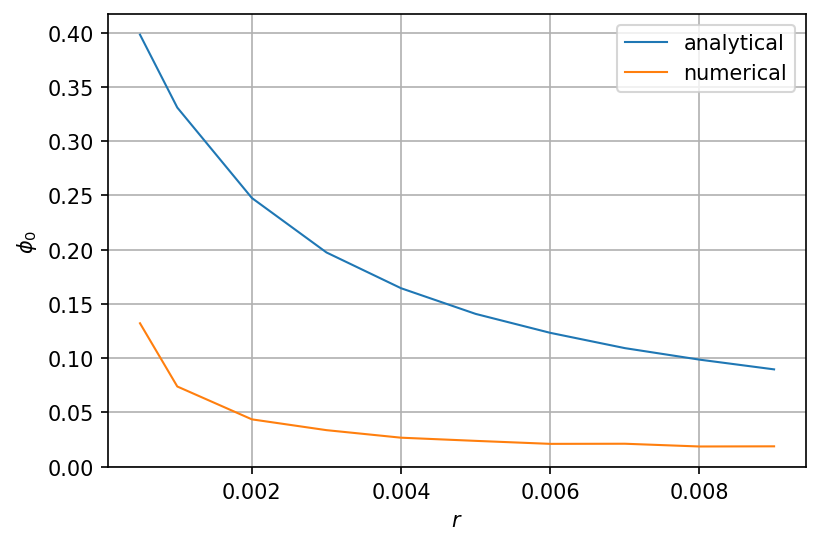

In [432]:
plt.figure(dpi=150)
plt.grid()
plt.xlabel("$r$")
plt.ylabel("$\phi_0$")
plt.plot(rates,phi0_ana,label="analytical",lw=1)
plt.plot(rates,phi0_num,label="numerical",lw=1)
plt.legend()